In [4]:
pip install openTSNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
from openTSNE import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
data = pd.read_sas("/content/gdrive/MyDrive/DRIM challenge/construct_red.sas7bdat")

In [8]:
data1 = data[data.CHRONIQUE == b'CHR2']
data2 = data[data.CHRONIQUE == b'CHR8']
data3 = data[data.CHRONIQUE == b'Totale']

In [9]:
data.head()

,TRIMESTRE,CHRONIQUE,DR,mean_1,median_1,p5_1,p10_1,p25_1,p75_1,p90_1,...,CD_MOD_HABI_2,CD_PROF_1,CD_PROF_2,CD_PROF_3,CD_QUAL_VEH_1,CD_QUAL_VEH_2,dtf_per_trt,PIB,Inflation,Tx_cho
0,2008-12-31,b'CHR2',0.0030,0.994843,0.995192,0.992081,0.992530,0.993691,0.996259,0.996862,...,0.727543,0.070852,0.351216,0.577932,0.392129,0.607871,b'Q42008',497736.0,1.760576,7.8
1,2008-12-31,b'CHR8',0.1924,0.945694,0.953968,0.870889,0.890246,0.924743,0.976024,0.990229,...,0.320747,0.181759,0.541801,0.276439,0.548512,0.451488,b'Q42008',497736.0,1.760576,7.8
2,2008-12-31,b'Totale',0.0240,0.975114,0.993819,0.909173,0.940773,0.978358,0.998133,0.999224,...,0.656708,0.102888,0.370723,0.526389,0.451145,0.548855,b'Q42008',497736.0,1.760576,7.8
3,2009-03-31,b'CHR2',0.0025,0.994782,0.995192,0.992097,0.992579,0.993694,0.996275,0.996862,...,0.738127,0.068228,0.342803,0.588969,0.376661,0.623339,b'Q12009',489227.0,0.624887,8.6
4,2009-03-31,b'CHR8',0.1436,0.947787,0.956417,0.870889,0.893328,0.927447,0.978988,0.991735,...,0.346455,0.177304,0.532900,0.289797,0.543935,0.456065,b'Q12009',489227.0,0.624887,8.6


# Kiff

## Parameters plot

In [10]:
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    import matplotlib

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)


## About macro factor

Question:


*   peut on faire une réduction de dimension sur les données macroéconomique
  * métriques: identification de la crise de 2008




In [11]:
data["crisis"] = pd.DataFrame([0]*10+[1]*(10)+[2]*68)
y_crisis = data["crisis"]

colors_bool = {
    0: "#FF2D00", #crisis
    1: "#FFAC00", #post-crisis
    2: "#46FF00", #normal-time
}

In [12]:
x_macro = data[["PIB","Inflation","Tx_cho"]]

In [13]:
help(TSNE)

Help on class TSNE in module openTSNE.tsne:

class TSNE(sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, perplexity=30, learning_rate='auto', early_exaggeration_iter=250, early_exaggeration=12, n_iter=500, exaggeration=None, dof=1, theta=0.5, n_interpolation_points=3, min_num_intervals=50, ints_in_interval=1, initialization='pca', metric='euclidean', metric_params=None, initial_momentum=0.5, final_momentum=0.8, max_grad_norm=None, max_step_norm=5, n_jobs=1, neighbors='auto', negative_gradient_method='auto', callbacks=None, callbacks_every_iters=50, random_state=None, verbose=False)
 |  
 |  t-Distributed Stochastic Neighbor Embedding.
 |  
 |  Please see the :ref:`parameter-guide` for more information.
 |  
 |  Parameters
 |  ----------
 |  n_components: int
 |      The dimension of the embedding space. This deafults to 2 for easy
 |      visualization, but sometimes 1 is used for t-SNE heatmaps. t-SNE is
 |      not designed to embed into higher dimension and please note that
 |  

In [14]:
%%time 
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_macro = tsne.fit(x_macro.to_numpy())

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 75 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.8606, 50 iterations in 0.0359 sec
Iteration  100, KL divergence 0.5961, 50 iterations in 0.0350 sec
Iteration  150, KL divergence 0.7667, 50 iterations in 0.0343 sec
Iteration  200, KL divergence 0.8420, 50 iterations in 0.0326 sec
Iteration  250, KL divergence 0.9074, 50 iterations in 0.0322 sec
   --> Time elapsed: 0.18 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

In [15]:
#to save the object
import pickle
pickle_out = open("x_macro.pickle","wb")
pickle.dump(emb_x_macro, pickle_out)
pickle_out.close()

#to load the object
#pickle_in = open("x_macro.pickle","wb")
#emb_x_macro = pickle.load(pickle_in)

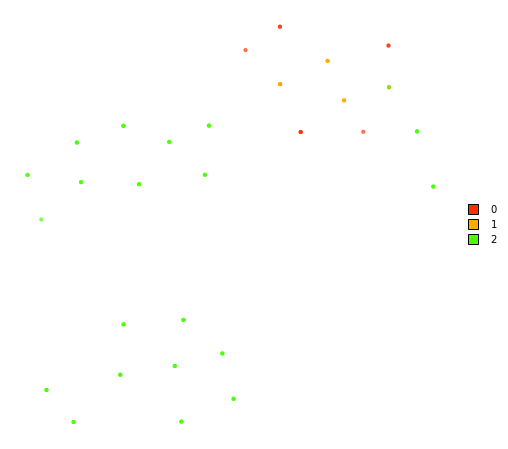

In [16]:
plot(emb_x_macro, y_crisis,s=10, colors=colors_bool)

## About charecteristics of individuals

In [17]:
data["x1"] = pd.DataFrame(['CHR2','CHR8','Totale']*26)
y_1 = data["x1"]

colors_chron = {
    'CHR2': "#FF2D00", 
    'CHR8': "#FFAC00", 
    'Totale': "#46FF00", 
}

In [18]:
x_carac = data[['CD_TY_CLI_RCI_1', 'CD_TY_CLI_RCI_2','CD_ETA_CIV_1', 'CD_ETA_CIV_2','CD_MOD_HABI_1', 
'CD_MOD_HABI_2','CD_PROF_1','CD_PROF_2', 'CD_PROF_3','CD_QUAL_VEH_1','CD_QUAL_VEH_2']]

In [19]:
%%time 
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_carac = tsne.fit(x_carac.to_numpy())

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 75 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.0438, 50 iterations in 0.0241 sec
Iteration  100, KL divergence 0.8381, 50 iterations in 0.0232 sec
Iteration  150, KL divergence 0.5711, 50 iterations in 0.0211 sec
Iteration  200, KL divergence 0.9017, 50 iterations in 0.0214 sec
Iteration  250, KL divergence 0.6272, 50 iterations in 0.0357 sec
   --> Time elapsed: 0.13 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

In [20]:
emb_x_carac

TSNEEmbedding([[ 6.79040805e+00, -2.04215176e+00],
               [-1.28759639e+01,  1.53952608e-01],
               [ 4.17459365e+00,  3.64762275e+00],
               [ 6.86583263e+00, -2.32018676e+00],
               [-1.28238602e+01,  2.92484007e-01],
               [ 4.30339313e+00,  3.61923604e+00],
               [ 6.87720694e+00, -2.36711520e+00],
               [-1.27505522e+01,  3.68914779e-01],
               [ 4.36281315e+00,  3.59319511e+00],
               [ 6.91076379e+00, -2.49406864e+00],
               [-1.27432792e+01,  3.82479028e-01],
               [ 4.42372819e+00,  3.57879241e+00],
               [ 6.95990649e+00, -2.73482218e+00],
               [-1.27335199e+01,  3.01998546e-01],
               [ 4.61019508e+00,  3.54305394e+00],
               [ 6.97775941e+00, -2.84744910e+00],
               [-1.26506029e+01,  6.29183309e-02],
               [ 4.73178730e+00,  3.50065569e+00],
               [ 6.99868083e+00, -2.99028548e+00],
               [-1.25860619e+01

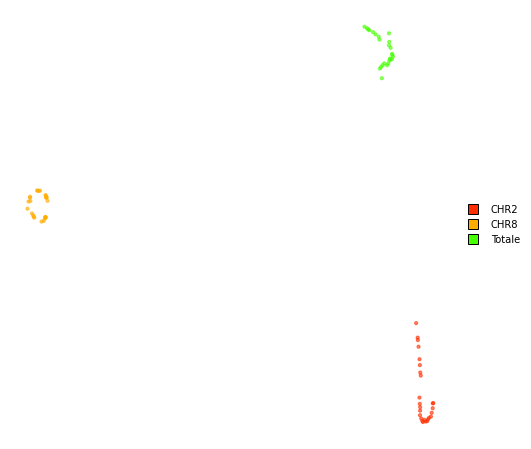

In [21]:
plot(emb_x_carac, y_1,s=10, colors=colors_chron)

## About subvariables factor link with chronique

In [22]:
data["x1"] = pd.DataFrame(['CHR2','CHR8','Totale']*26)
y_1 = data["x1"]

colors_chron = {
    'CHR2': "#FF2D00", 
    'CHR8': "#FFAC00", 
    'Totale': "#46FF00", 
}

In [23]:
x_1 = data[['mean_1','median_1','p5_1','p10_1','p25_1','p75_1','p90_1','p95_1']]

In [24]:
%%time 
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_1 = tsne.fit(x_1.to_numpy())

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 75 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.4934, 50 iterations in 0.0231 sec
Iteration  100, KL divergence 0.7568, 50 iterations in 0.0299 sec
Iteration  150, KL divergence 0.3880, 50 iterations in 0.0217 sec
Iteration  200, KL divergence 0.6787, 50 iterations in 0.0209 sec
Iteration  250, KL divergence 0.5123, 50 iterations in 0.0206 sec
   --> Time elapsed: 0.12 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

In [25]:
emb_x_1

TSNEEmbedding([[-13.8574254 ,   8.51428661],
               [  0.35112739, -14.6672905 ],
               [ 13.3496448 ,   5.93301532],
               [-13.79820286,   8.54491423],
               [  0.42505668, -14.61616468],
               [ 13.35492947,   6.00217018],
               [-13.88813133,   8.3570281 ],
               [  0.54221185, -14.53356605],
               [ 13.35041593,   6.035472  ],
               [-13.84002369,   8.52517268],
               [  0.69467239, -14.425691  ],
               [ 13.34377068,   6.08120991],
               [-13.88536261,   8.35177482],
               [  0.70429888, -14.41836901],
               [ 13.30397066,   6.20212445],
               [-13.78967091,   8.27356062],
               [  0.73310982, -14.3979918 ],
               [ 13.20114071,   6.28548972],
               [-13.61791864,   8.42031598],
               [  0.784129  , -14.36164152],
               [ 13.18035056,   6.30549514],
               [-13.88396108,   8.47659829],
          

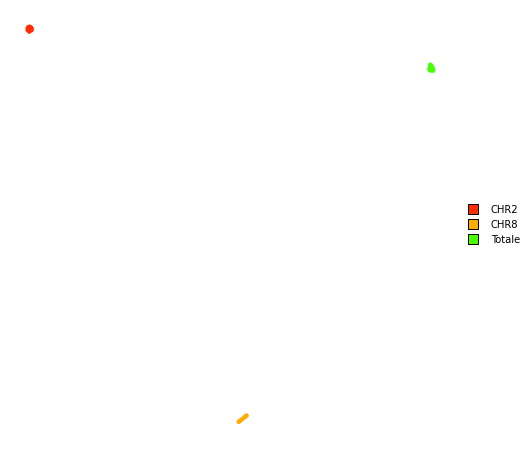

In [26]:
plot(emb_x_1, y_1,s=10, colors=colors_chron)

# Moins Kiff

## Analyzis of PD

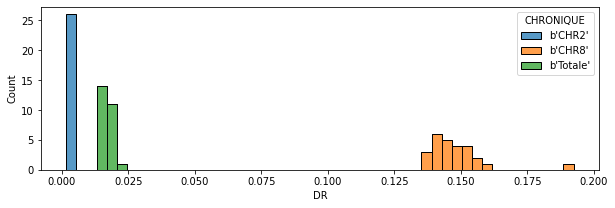

In [27]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

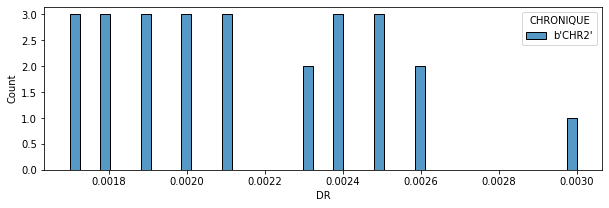

In [28]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data1, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

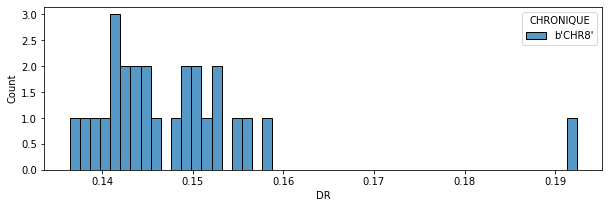

In [29]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data2, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

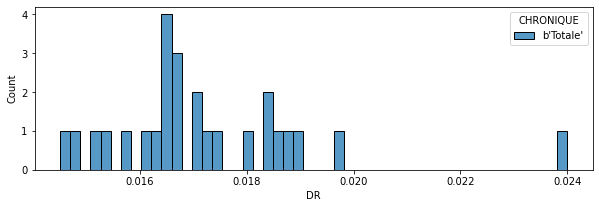

In [30]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data3, x="DR", hue="CHRONIQUE",multiple="stack",bins=50)

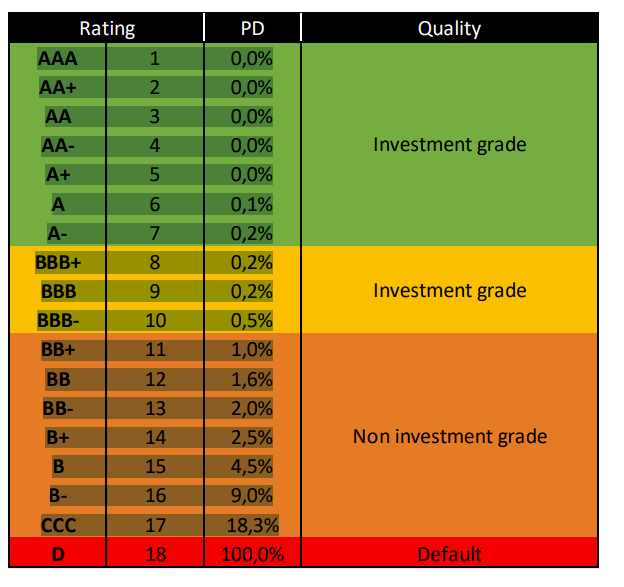

In [31]:
 def rating(dr):
  if dr<0.016:
    return 'A'
  elif 0.016<=dr<0.017:
    return 'B'
  elif 0.017<=dr<0.018:
    return 'C'
  elif 0.018<=dr<0.02:
    return 'D'
  else:
    return 'E'

In [32]:
data3['grade'] = data3['DR'].map(rating)
y_grade = data3['grade']
colors_grade = {
    'A': "#57D40A", 
    'B': "#9AD40A", 
    'C': "#D4D10A", 
    'D': "#FF8700", 
    'E': "#FF0C00", 
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


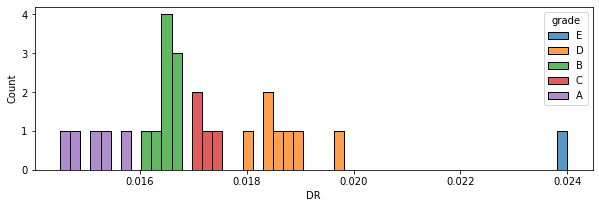

In [33]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=data3, x="DR", hue="grade",multiple="stack",bins=50)

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 25 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4501, 50 iterations in 0.0184 sec
Iteration  100, KL divergence 1.4962, 50 iterations in 0.0201 sec
Iteration  150, KL divergence 1.5655, 50 iterations in 0.0232 sec
Iteration  200, KL divergence 1.4470, 50 iterations in 0.0183 sec
Iteration  250, KL divergence 1.2257, 50 iterations in 0.0206 sec
   --> Time elapsed: 0.12 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

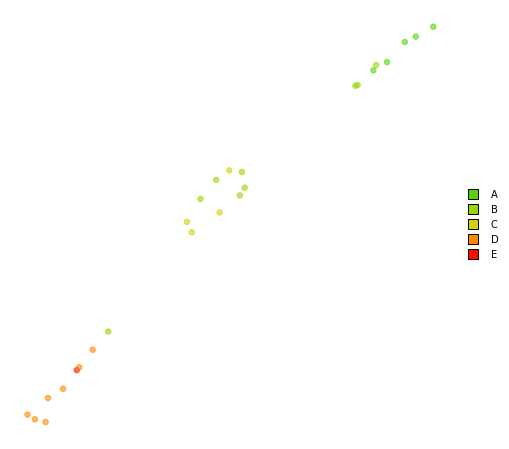

In [34]:
x_macro_3 = data3[["PIB","Inflation","Tx_cho"]]
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_macro_3 = tsne.fit(x_macro_3.to_numpy())
plot(emb_x_macro_3, y_grade,s=30, colors=colors_grade)

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 25 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.4488, 50 iterations in 0.0430 sec
Iteration  100, KL divergence 1.4672, 50 iterations in 0.0180 sec
Iteration  150, KL divergence 1.6251, 50 iterations in 0.0477 sec
Iteration  200, KL divergence 1.3952, 50 iterations in 0.0327 sec
Iteration  250, KL divergence 1.5379, 50 iterations in 0.0353 sec
   --> Time elapsed: 0.20 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

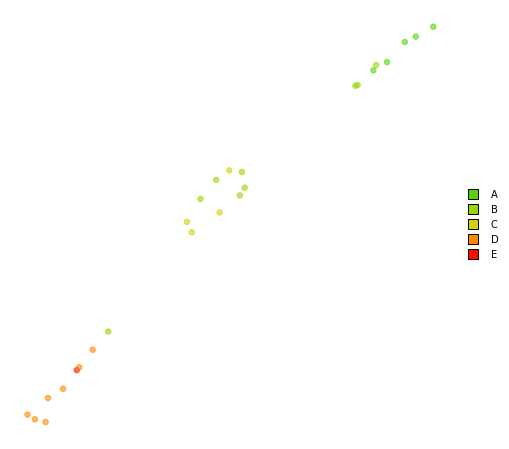

In [35]:
x_carac = data3[['CD_TY_CLI_RCI_1', 'CD_TY_CLI_RCI_2','CD_ETA_CIV_1', 'CD_ETA_CIV_2','CD_MOD_HABI_1', 
'CD_MOD_HABI_2','CD_PROF_1','CD_PROF_2', 'CD_PROF_3','CD_QUAL_VEH_1','CD_QUAL_VEH_2']]
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_carac3 = tsne.fit(x_carac.to_numpy())
plot(emb_x_macro_3, y_grade,s=30, colors=colors_grade)

--------------------------------------------------------------------------------
TSNE(perplexity=25, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 25 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 1.3998, 50 iterations in 0.0201 sec
Iteration  100, KL divergence 1.4672, 50 iterations in 0.0204 sec
Iteration  150, KL divergence 1.5114, 50 iterations in 0.0191 sec
Iteration  200, KL divergence 1.1079, 50 iterations in 0.0461 sec
Iteration  250, KL divergence 1.5609, 50 iterations in 0.0364 sec
   --> Time elapsed: 0.16 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iteratio

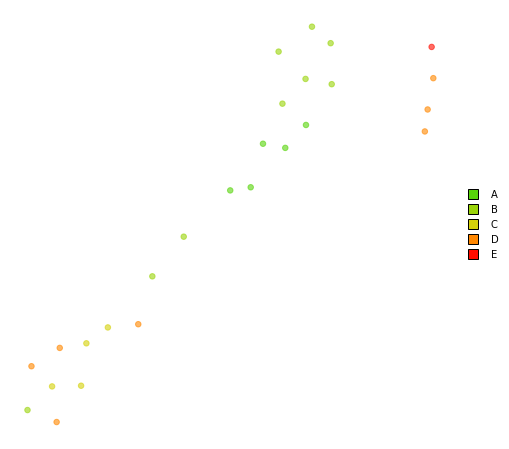

In [36]:
x_1_3 = data3[['mean_1','median_1','p5_1','p10_1','p25_1','p75_1','p90_1','p95_1']]
tsne = TSNE(perplexity=25, #preserve distances to a third of the data set 
            metric='euclidean', 
            n_components=2, #project on 1D 
            random_state=42,
            verbose=True)
emb_x_1_3 = tsne.fit(x_1_3.to_numpy())
plot(emb_x_1_3, y_grade,s=30, colors=colors_grade)

## Bivariate analysis

In [37]:
data3.columns

Index(['TRIMESTRE', 'CHRONIQUE', 'DR', 'mean_1', 'median_1', 'p5_1', 'p10_1',
       'p25_1', 'p75_1', 'p90_1', 'p95_1', 'mean_2', 'median_2', 'p5_2',
       'p10_2', 'p25_2', 'p75_2', 'p90_2', 'p95_2', 'mean_3', 'median_3',
       'p5_3', 'p10_3', 'p25_3', 'p75_3', 'p90_3', 'p95_3', 'mean_4',
       'median_4', 'p5_4', 'p10_4', 'p25_4', 'p75_4', 'p90_4', 'p95_4',
       'mean_5', 'median_5', 'p5_5', 'p10_5', 'p25_5', 'p75_5', 'p90_5',
       'p95_5', 'mean_6', 'median_6', 'p5_6', 'p10_6', 'p25_6', 'p75_6',
       'p90_6', 'p95_6', 'mean_7', 'median_7', 'p5_7', 'p10_7', 'p25_7',
       'p75_7', 'p90_7', 'p95_7', 'mean_8', 'median_8', 'p5_8', 'p10_8',
       'p25_8', 'p75_8', 'p90_8', 'p95_8', 'CD_TY_CLI_RCI_1',
       'CD_TY_CLI_RCI_2', 'CD_ETA_CIV_1', 'CD_ETA_CIV_2', 'CD_MOD_HABI_1',
       'CD_MOD_HABI_2', 'CD_PROF_1', 'CD_PROF_2', 'CD_PROF_3', 'CD_QUAL_VEH_1',
       'CD_QUAL_VEH_2', 'dtf_per_trt', 'PIB', 'Inflation', 'Tx_cho', 'grade'],
      dtype='object')

In [38]:
cols = ['CD_TY_CLI_RCI_1', 'CD_TY_CLI_RCI_2', 'CD_ETA_CIV_1', 'CD_ETA_CIV_2', 'CD_MOD_HABI_1',
       'CD_MOD_HABI_2', 'CD_PROF_1', 'CD_PROF_2', 'CD_PROF_3', 'CD_QUAL_VEH_1',
       'CD_QUAL_VEH_2']

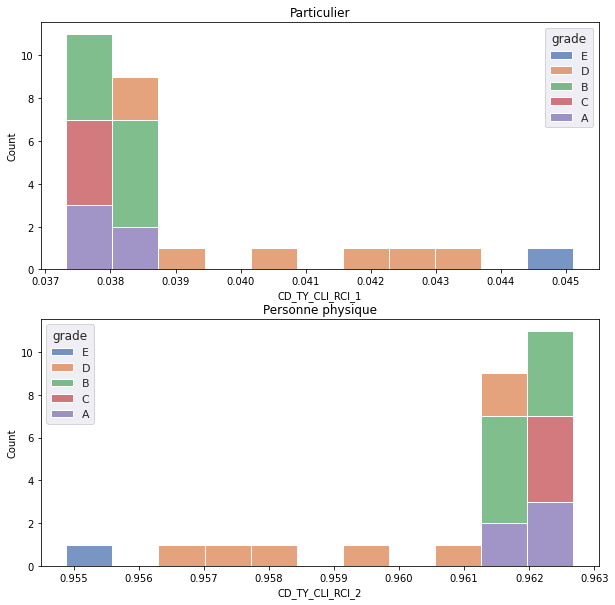

In [39]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_TY_CLI_RCI_1', hue='grade',multiple="stack", ax=axs[0])
axs[0].set_title("Particulier")
sns.histplot(data=data3, x='CD_TY_CLI_RCI_2', hue='grade',multiple="stack", ax=axs[1])
axs[1].set_title("Personne physique")
plt.show()

Plus il y a de particulier et moins il y a un risque de défault

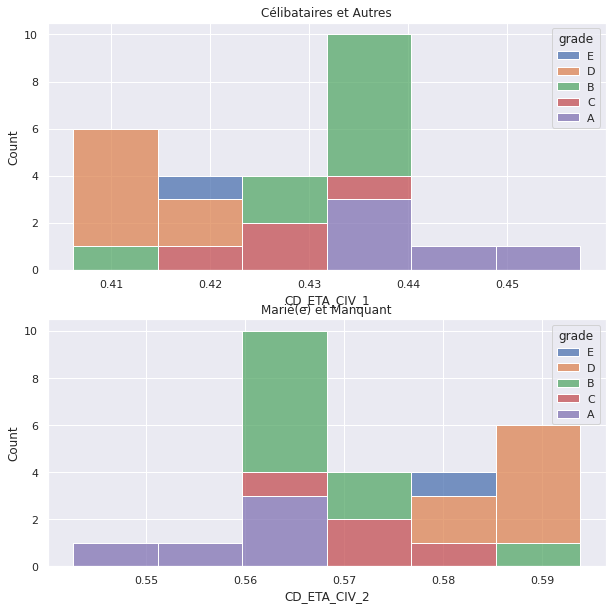

In [40]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_ETA_CIV_1', hue='grade',multiple="stack", ax=axs[0])
axs[0].set_title("Célibataires et Autres")
sns.histplot(data=data3, x='CD_ETA_CIV_2',hue='grade',multiple="stack",ax=axs[1])
axs[1].set_title("Marié(e) et Manquant")
plt.show()

Plus la répartition de la situation amouereuse des gens est moitié moitié et moins DR est grand

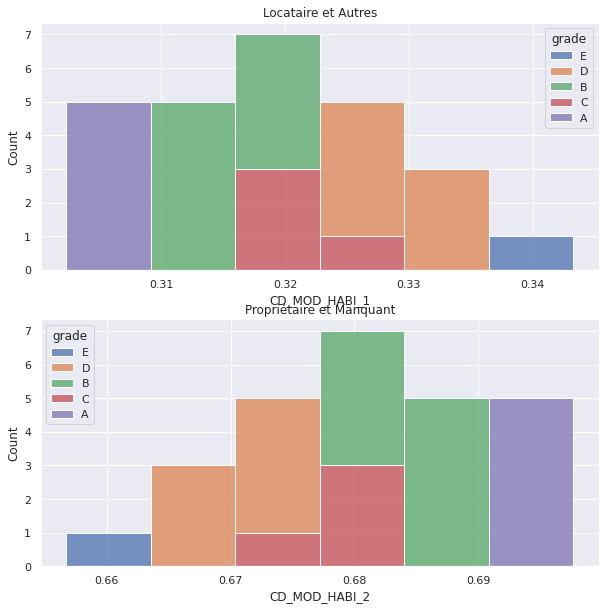

In [41]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_MOD_HABI_1', hue='grade',multiple="stack",ax=axs[0])
axs[0].set_title("Locataire et Autres")
sns.histplot(data=data3, x='CD_MOD_HABI_2', hue='grade',multiple="stack",ax=axs[1])
axs[1].set_title("Propriétaire et Manquant")
plt.show()

Plus il y a de locataire et moins DR et grand

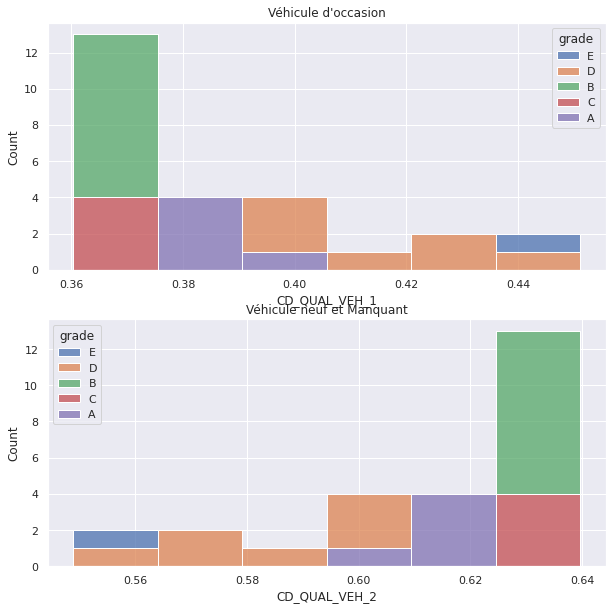

In [42]:
fig, axs = plt.subplots(2, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_QUAL_VEH_1', hue='grade',multiple="stack",ax=axs[0])
axs[0].set_title("Véhicule d'occasion")
sns.histplot(data=data3, x='CD_QUAL_VEH_2', hue='grade',multiple="stack",ax=axs[1])
axs[1].set_title("Véhicule neuf et Manquant")
plt.show()

On n'en déduit pas grand chose

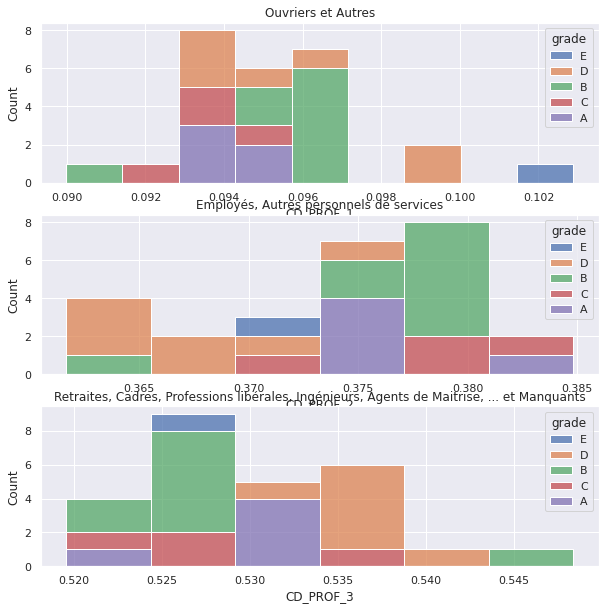

In [43]:
fig, axs = plt.subplots(3, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='CD_PROF_1', hue='grade',multiple="stack", ax=axs[0])
axs[0].set_title("Ouvriers et Autres")
sns.histplot(data=data3, x='CD_PROF_2', hue='grade',multiple="stack", ax=axs[1])
axs[1].set_title("Employés, Autres personnels de services")
sns.histplot(data=data3, x='CD_PROF_3', hue='grade',multiple="stack", ax=axs[2])
axs[2].set_title("Retraites, Cadres, Professions libérales, Ingénieurs, Agents de Maitrise, ... et Manquants")
plt.show()

On n'en déduit pas grand chose

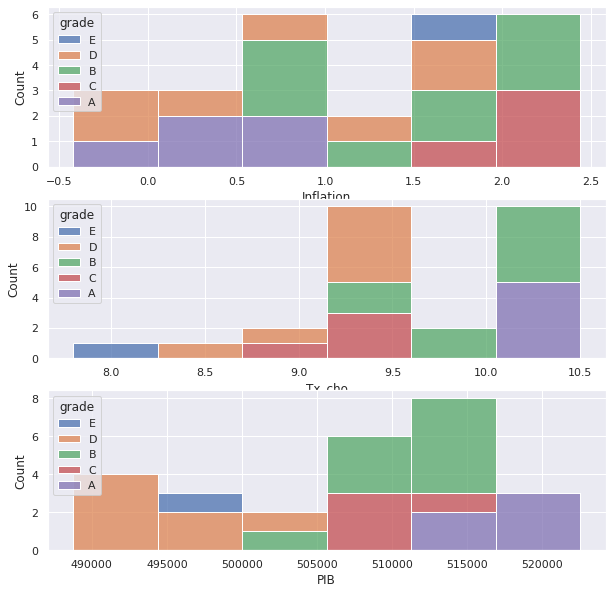

In [44]:
fig, axs = plt.subplots(3, figsize=(10, 10))
sns.set(style="darkgrid")
sns.histplot(data=data3, x='Inflation', hue='grade',multiple="stack", ax=axs[0])
sns.histplot(data=data3, x='Tx_cho', hue='grade',multiple="stack", ax=axs[1])
sns.histplot(data=data3, x='PIB', hue='grade',multiple="stack", ax=axs[2])
plt.show()

On déduit rien de l'inflation
étonnamment, plus le taux de chomage est élevé et plus DR est petit
Plus le PIB est grand, plus DR est petit


## Decision tree

In [45]:
data.columns

Index(['TRIMESTRE', 'CHRONIQUE', 'DR', 'mean_1', 'median_1', 'p5_1', 'p10_1',
       'p25_1', 'p75_1', 'p90_1', 'p95_1', 'mean_2', 'median_2', 'p5_2',
       'p10_2', 'p25_2', 'p75_2', 'p90_2', 'p95_2', 'mean_3', 'median_3',
       'p5_3', 'p10_3', 'p25_3', 'p75_3', 'p90_3', 'p95_3', 'mean_4',
       'median_4', 'p5_4', 'p10_4', 'p25_4', 'p75_4', 'p90_4', 'p95_4',
       'mean_5', 'median_5', 'p5_5', 'p10_5', 'p25_5', 'p75_5', 'p90_5',
       'p95_5', 'mean_6', 'median_6', 'p5_6', 'p10_6', 'p25_6', 'p75_6',
       'p90_6', 'p95_6', 'mean_7', 'median_7', 'p5_7', 'p10_7', 'p25_7',
       'p75_7', 'p90_7', 'p95_7', 'mean_8', 'median_8', 'p5_8', 'p10_8',
       'p25_8', 'p75_8', 'p90_8', 'p95_8', 'CD_TY_CLI_RCI_1',
       'CD_TY_CLI_RCI_2', 'CD_ETA_CIV_1', 'CD_ETA_CIV_2', 'CD_MOD_HABI_1',
       'CD_MOD_HABI_2', 'CD_PROF_1', 'CD_PROF_2', 'CD_PROF_3', 'CD_QUAL_VEH_1',
       'CD_QUAL_VEH_2', 'dtf_per_trt', 'PIB', 'Inflation', 'Tx_cho', 'crisis',
       'x1'],
      dtype='object')

In [46]:

target_names = ['A','B','C','D','E']

feature_names = ['CD_TY_CLI_RCI_1', 'CD_ETA_CIV_1', 'CD_MOD_HABI_1', 'CD_PROF_1', 'CD_PROF_2', 'CD_QUAL_VEH_1', 'PIB', 'Inflation', 'Tx_cho']


In [47]:
Y = data3['grade']
X = data3[feature_names]

In [48]:
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
Y_train = Y[:int(X.shape[0]*0.7)]
Y_test = Y[int(X.shape[0]*0.7):]

In [49]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.375

In [50]:
import graphviz 
from subprocess import check_call
dot_data = tree.export_graphviz(clf, out_file='tree.dot',
                      feature_names=feature_names,  
                      class_names=target_names,filled=True,rounded=True,)  
%time graph = graphviz.Source(dot_data)  
%time graph 


CPU times: user 32 µs, sys: 2 µs, total: 34 µs
Wall time: 40.8 µs
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs


Error: <stdin>: syntax error in line 1 near 'None'


CalledProcessError: ignored

In [51]:
import pydot
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

On déduit que des variables assez importantes sont: 
* 'Tx_cho'
*   'CD_MOD_HABI_2'
*   'CD_TY_CLI_RCI_1'

On vérifie avec la matrice de corrélation


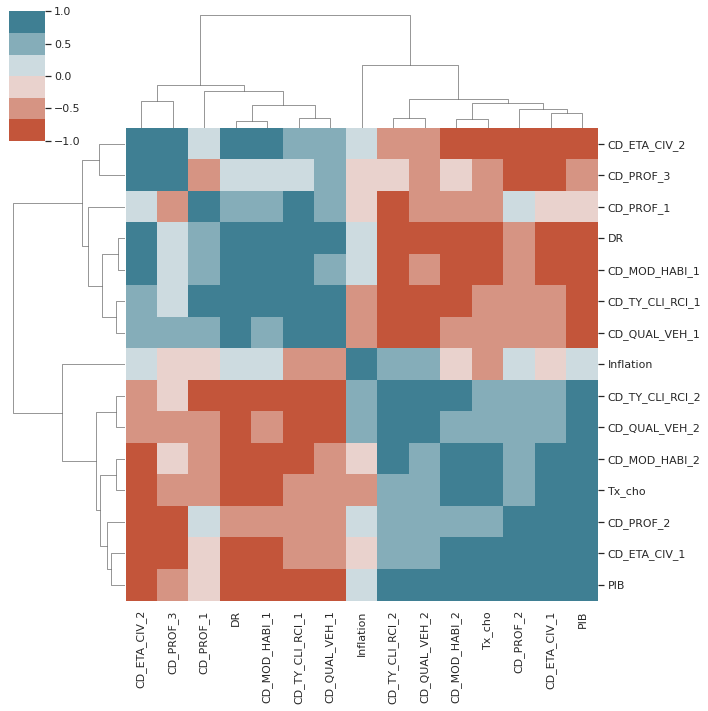

In [52]:
MatriceCorrelation3=data3.drop(data3.iloc[:, 3:3+8*8],axis = 1).corr()
sns.clustermap(MatriceCorrelation3, fmt='.2f', cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)